# DATA COLLECTION

In [12]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Correct dataset path (with leading space)
dataset_zip = "/content/drive/MyDrive/ NumberPlate Datset with annotation.zip"
extract_path = "/content/data"

# Create extract folder
import os
os.makedirs(extract_path, exist_ok=True)

# Unzip safely
!unzip -o "$dataset_zip" -d "$extract_path"

# List extracted structure
!ls -R $extract_path | head -50


Mounted at /content/drive
Archive:  /content/drive/MyDrive/ NumberPlate Datset with annotation.zip
  inflating: /content/data/best.pt   
  inflating: /content/data/images/images/20230327_170242.jpg  
  inflating: /content/data/images/images/20230327_170249.jpg  
  inflating: /content/data/images/images/20230327_170259.jpg  
  inflating: /content/data/images/images/20230418_125454.jpg  
  inflating: /content/data/images/images/20230425_163417.jpg  
  inflating: /content/data/images/images/20230515_095931.jpg  
  inflating: /content/data/images/images/20230515_125709.jpg  
  inflating: /content/data/images/images/20230515_131318.jpg  
  inflating: /content/data/images/images/20230515_133831.jpg  
  inflating: /content/data/images/images/20230516_131859.jpg  
  inflating: /content/data/images/images/20230516_154005.jpg  
  inflating: /content/data/images/images/20230516_154015.jpg  
  inflating: /content/data/images/images/20230516_154022.jpg  
  inflating: /content/data/images/images/202

In [14]:
import os, shutil, random


raw_img_dir = "/content/data/images/images"
raw_lbl_dir = "/content/data/yolo_labels"
yolo_dataset = "/content/yolo_dataset"


if os.path.exists(yolo_dataset):
    shutil.rmtree(yolo_dataset)
os.makedirs(f"{yolo_dataset}/images/train", exist_ok=True)
os.makedirs(f"{yolo_dataset}/labels/train", exist_ok=True)
os.makedirs(f"{yolo_dataset}/images/val", exist_ok=True)
os.makedirs(f"{yolo_dataset}/labels/val", exist_ok=True)

all_imgs = [f for f in os.listdir(raw_img_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
print("Total images found:", len(all_imgs))

random.shuffle(all_imgs)
split = int(0.8 * len(all_imgs))   # 80% train, 20% val
train_imgs, val_imgs = all_imgs[:split], all_imgs[split:]


for img in train_imgs:
    shutil.copy(os.path.join(raw_img_dir, img), f"{yolo_dataset}/images/train/")
    lbl = os.path.splitext(img)[0] + ".txt"
    if os.path.exists(os.path.join(raw_lbl_dir, lbl)):
        shutil.copy(os.path.join(raw_lbl_dir, lbl), f"{yolo_dataset}/labels/train/")


for img in val_imgs:
    shutil.copy(os.path.join(raw_img_dir, img), f"{yolo_dataset}/images/val/")
    lbl = os.path.splitext(img)[0] + ".txt"
    if os.path.exists(os.path.join(raw_lbl_dir, lbl)):
        shutil.copy(os.path.join(raw_lbl_dir, lbl), f"{yolo_dataset}/labels/val/")

print(" Dataset restructured")
print("Train images:", len(os.listdir(f'{yolo_dataset}/images/train')))
print("Val images:", len(os.listdir(f'{yolo_dataset}/images/val')))


Total images found: 410
✅ Dataset restructured
Train images: 328
Val images: 82


Image: /content/data/images/images/20230620_161309.jpg
Label: /content/data/yolo_labels/20230614_150935ll.txt


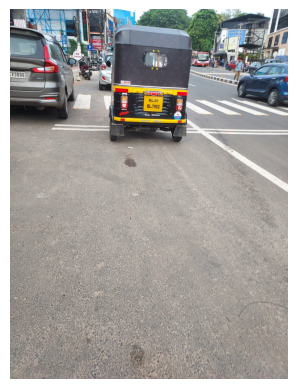

YOLO Annotation:
 0 0.464333 0.423625 0.107333 0.078250
0 0.378667 0.111250 0.116000 0.107500



In [6]:
import os, cv2, matplotlib.pyplot as plt

# Correct paths
image_dir = "/content/data/images/images"
label_dir = "/content/data/yolo_labels"

# Pick one sample image
sample_img = os.path.join(image_dir, os.listdir(image_dir)[0])
sample_lbl = os.path.join(label_dir, os.listdir(label_dir)[0])

print("Image:", sample_img)
print("Label:", sample_lbl)

# show image
img = cv2.imread(sample_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

# show annotation
with open(sample_lbl, "r") as f:
    print("YOLO Annotation:\n", f.read())


# PREPROCESSING

In [7]:
#Image Resizing & Normalization

import cv2, os

input_dir = "/content/yolo_dataset/images/train"
output_dir = "/content/preprocessed/train"
os.makedirs(output_dir, exist_ok=True)

for img_name in os.listdir(input_dir):
    img = cv2.imread(os.path.join(input_dir, img_name))
    if img is None:
        continue
    resized = cv2.resize(img, (640, 640))
    norm = resized / 255.0   # normalization
    cv2.imwrite(os.path.join(output_dir, img_name), (norm*255).astype("uint8"))

print(" Resized & normalized images saved in:", output_dir)


 Resized & normalized images saved in: /content/preprocessed/train


In [28]:
!pip uninstall -y albumentations
!pip install albumentations==1.3.0


Found existing installation: albumentations 1.3.0
Uninstalling albumentations-1.3.0:
  Successfully uninstalled albumentations-1.3.0
  Using cached albumentations-1.3.0-py3-none-any.whl.metadata (34 kB)
Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)


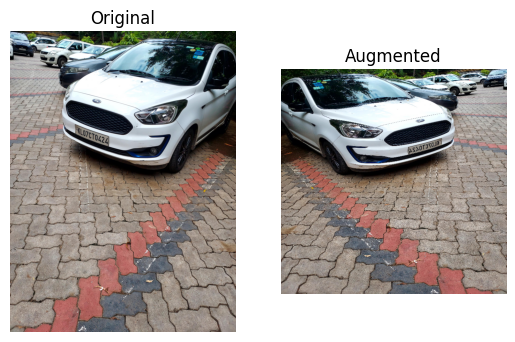

In [8]:
# Data Augmentation
import albumentations as A
import cv2
from matplotlib import pyplot as plt

transform = A.Compose([
    A.Resize(640, 640),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(10, 50), p=0.3),  # should now work
    A.HorizontalFlip(p=0.5),
])

img_path = "/content/yolo_dataset/images/train/20230614_150814ll.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

augmented = transform(image=img)
aug_img = augmented["image"]

plt.subplot(1,2,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(aug_img); plt.title("Augmented"); plt.axis("off")
plt.show()


In [9]:
# Filtering Poor-Quality Images

import numpy as np

def is_poor_quality(img_path, blur_thresh=100, min_size=200):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return True

    # Blur detection (variance of Laplacian)
    blur_val = cv2.Laplacian(img, cv2.CV_64F).var()
    if blur_val < blur_thresh:
        return True

    # Resolution check
    h, w = img.shape
    if h < min_size or w < min_size:
        return True

    return False

bad_images = []
for img_name in os.listdir(input_dir):
    img_path = os.path.join(input_dir, img_name)
    if is_poor_quality(img_path):
        bad_images.append(img_name)

print(f" Found {len(bad_images)} poor-quality images")
print("Examples:", bad_images[:5])


 Found 10 poor-quality images
Examples: ['20230620_155828ll.jpg', '20230620_160022ll.jpg', '20230614_151016ll.jpg', '20230614_151233ll.jpg', '20230614_151238ll.jpg']


# Exploratory Data Analysis (EDA)

In [10]:
# Dataset Composition

import os

train_imgs = len(os.listdir("/content/yolo_dataset/images/train"))
val_imgs = len(os.listdir("/content/yolo_dataset/images/val"))
train_lbls = len(os.listdir("/content/yolo_dataset/labels/train"))
val_lbls = len(os.listdir("/content/yolo_dataset/labels/val"))

print(f"Train Images: {train_imgs}, Train Labels: {train_lbls}")
print(f"Val Images: {val_imgs}, Val Labels: {val_lbls}")


Train Images: 93, Train Labels: 93
Val Images: 22, Val Labels: 22


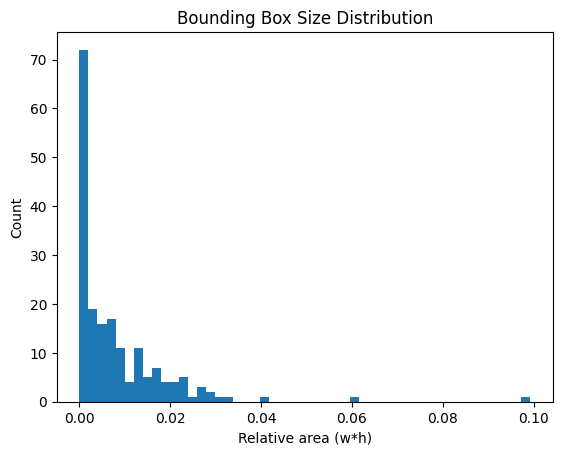

In [11]:
# Bounding Box Distribution

import matplotlib.pyplot as plt

box_sizes = []
lbl_dir = "/content/yolo_dataset/labels/train"
for lbl_file in os.listdir(lbl_dir):
    with open(os.path.join(lbl_dir, lbl_file)) as f:
        for line in f:
            _, x, y, w, h = map(float, line.strip().split())
            box_sizes.append(w*h)

plt.hist(box_sizes, bins=50)
plt.title("Bounding Box Size Distribution")
plt.xlabel("Relative area (w*h)")
plt.ylabel("Count")
plt.show()


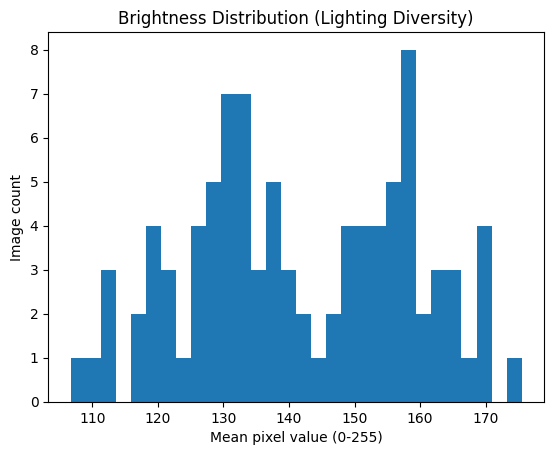

In [12]:
# Lighting Conditions & Weather Variability

import cv2, numpy as np

brightness_vals = []
img_dir = "/content/yolo_dataset/images/train"
for f in os.listdir(img_dir)[:200]:  # sample 200 for speed
    img = cv2.imread(os.path.join(img_dir, f), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        brightness_vals.append(np.mean(img))

plt.hist(brightness_vals, bins=30)
plt.title("Brightness Distribution (Lighting Diversity)")
plt.xlabel("Mean pixel value (0-255)")
plt.ylabel("Image count")
plt.show()


In [15]:
# Augmentation Effects
import albumentations as A
import cv2, os, shutil
from tqdm import tqdm
IMG_DIR = "/content/yolo_dataset/images/train"
LBL_DIR = "/content/yolo_dataset/labels/train"


OUT_IMG_DIR = "/content/yolo_augmented/images/train"
OUT_LBL_DIR = "/content/yolo_augmented/labels/train"

os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_LBL_DIR, exist_ok=True)


transform = A.Compose([
    A.Resize(640, 640),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(10, 50), p=0.3),
    A.HorizontalFlip(p=0.5),
    A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), p=0.5)
], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))


for img_file in tqdm(os.listdir(IMG_DIR)):
    if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(IMG_DIR, img_file)
    lbl_path = os.path.join(LBL_DIR, img_file.rsplit(".", 1)[0] + ".txt")


    if not os.path.exists(lbl_path):
        continue


    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape


    bboxes, classes = [], []
    with open(lbl_path, "r") as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            bboxes.append([x, y, bw, bh])
            classes.append(int(cls))


    augmented = transform(image=img, bboxes=bboxes, class_labels=classes)
    aug_img, aug_boxes, aug_classes = augmented["image"], augmented["bboxes"], augmented["class_labels"]


    out_img_path = os.path.join(OUT_IMG_DIR, img_file)
    cv2.imwrite(out_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))


    out_lbl_path = os.path.join(OUT_LBL_DIR, img_file.rsplit(".", 1)[0] + ".txt")
    with open(out_lbl_path, "w") as f:
        for cls, (x, y, bw, bh) in zip(aug_classes, aug_boxes):
            f.write(f"{cls} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

print(" Augmentation complete. Saved to /content/yolo_augmented")


100%|██████████| 93/93 [00:18<00:00,  5.05it/s]

 Augmentation complete. Saved to /content/yolo_augmented


In [15]:
# Merge+split
import os, shutil, random


orig_root = "/content/yolo_dataset"
aug_root  = "/content/yolo_augmented"
final_root = "/content/yolo_dataset_final"


for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    os.makedirs(os.path.join(final_root, sub), exist_ok=True)

def copy_files(src_img_dir, src_lbl_dir, dest_img_dir, dest_lbl_dir):
    if not os.path.exists(src_img_dir): return
    for img in os.listdir(src_img_dir):
        if not (img.endswith(".jpg") or img.endswith(".png")):
            continue
        lbl = img.rsplit(".",1)[0] + ".txt"
        shutil.copy(os.path.join(src_img_dir, img), os.path.join(dest_img_dir, img))
        if os.path.exists(os.path.join(src_lbl_dir, lbl)):
            shutil.copy(os.path.join(src_lbl_dir, lbl), os.path.join(dest_lbl_dir, lbl))


copy_files(os.path.join(orig_root, "images/train"), os.path.join(orig_root, "labels/train"),
           os.path.join(final_root, "images/train"), os.path.join(final_root, "labels/train"))
copy_files(os.path.join(orig_root, "images/val"), os.path.join(orig_root, "labels/val"),
           os.path.join(final_root, "images/train"), os.path.join(final_root, "labels/train"))  # put val together for resplit


copy_files(os.path.join(aug_root, "images/train"), os.path.join(aug_root, "labels/train"),
           os.path.join(final_root, "images/train"), os.path.join(final_root, "labels/train"))

print(" Original + Augmented merged into", final_root)


train_img_dir = os.path.join(final_root, "images/train")
val_img_dir   = os.path.join(final_root, "images/val")
train_lbl_dir = os.path.join(final_root, "labels/train")
val_lbl_dir   = os.path.join(final_root, "labels/val")


all_imgs = os.listdir(train_img_dir)

if len(all_imgs) < 2:
    print(f" Not enough images to split! Found only {len(all_imgs)} images in train.")
    print(" Keeping everything in train (no validation set).")
else:
    val_count = max(1, int(len(all_imgs) * 0.2))  # 20% validation
    val_count = min(len(all_imgs)-1, val_count)   # ensure not larger than population
    val_samples = random.sample(all_imgs, val_count)

    for img in val_samples:
        shutil.move(os.path.join(train_img_dir, img), os.path.join(val_img_dir, img))
        lbl = img.rsplit(".",1)[0] + ".txt"
        if os.path.exists(os.path.join(train_lbl_dir, lbl)):
            shutil.move(os.path.join(train_lbl_dir, lbl), os.path.join(val_lbl_dir, lbl))

print(" Final dataset split complete")
print("Train images:", len(os.listdir(train_img_dir)))
print("Val images:", len(os.listdir(val_img_dir)))


 Original + Augmented merged into /content/yolo_dataset_final
 Final dataset split complete
Train images: 328
Val images: 82


In [23]:
# Dataset Creation
import os

yaml_path = "/content/yolo_dataset_final/dataset.yaml"

dataset_yaml = f"""
train: {os.path.abspath('/content/yolo_dataset_final/images/train')}
val: {os.path.abspath('/content/yolo_dataset_final/images/val')}

nc: 1
names: ['number_plate']
"""


with open(yaml_path, "w") as f:
    f.write(dataset_yaml)

print(" dataset.yaml created at:", yaml_path)


 dataset.yaml created at: /content/yolo_dataset_final/dataset.yaml


In [18]:
!cat /content/yolo_dataset_final/dataset.yaml



train: /content/yolo_dataset_final/images/train
val: /content/yolo_dataset_final/images/val

nc: 1
names: ['number_plate']


# MODEL TRAINING

In [19]:
from ultralytics import YOLO
import torch

#  Load a pretrained YOLOv8 model
model = YOLO("yolov8s.pt")

device = "0" if torch.cuda.is_available() else "cpu"
print("Training on:", "GPU" if device=="0" else "CPU")

#  Train with fine-tuned hyperparameters
results = model.train(
    data="/content/yolo_dataset_final/dataset.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=0.001,
    optimizer="Adam",
    device=device,
    workers=2,
    cos_lr=True,
    patience=10,
    mosaic=1.0
)

#  Save trained weights path
print("✅ Training complete. Best model saved at:", model.ckpt_path)


Training on: GPU
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/yolo_dataset_final/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=10, perspective=0.0, plots=T

# EVALUATION

 Evaluating model on validation set...
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3485.2±498.4 MB/s, size: 5686.5 KB)
val: Scanning /content/yolo_dataset_final/labels/val.cache... 24 images, 58 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 82/82 86437.0it/s 0.0s
val: /content/yolo_dataset_final/images/val/20230327_170242.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset_final/images/val/20230516_154015.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset_final/images/val/20230516_154042.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset_final/images/val/20230516_154219.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset_final/images/val/20230516_154327.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset_final/images/val/20230516_154343.jpg: corrupt JPEG restor

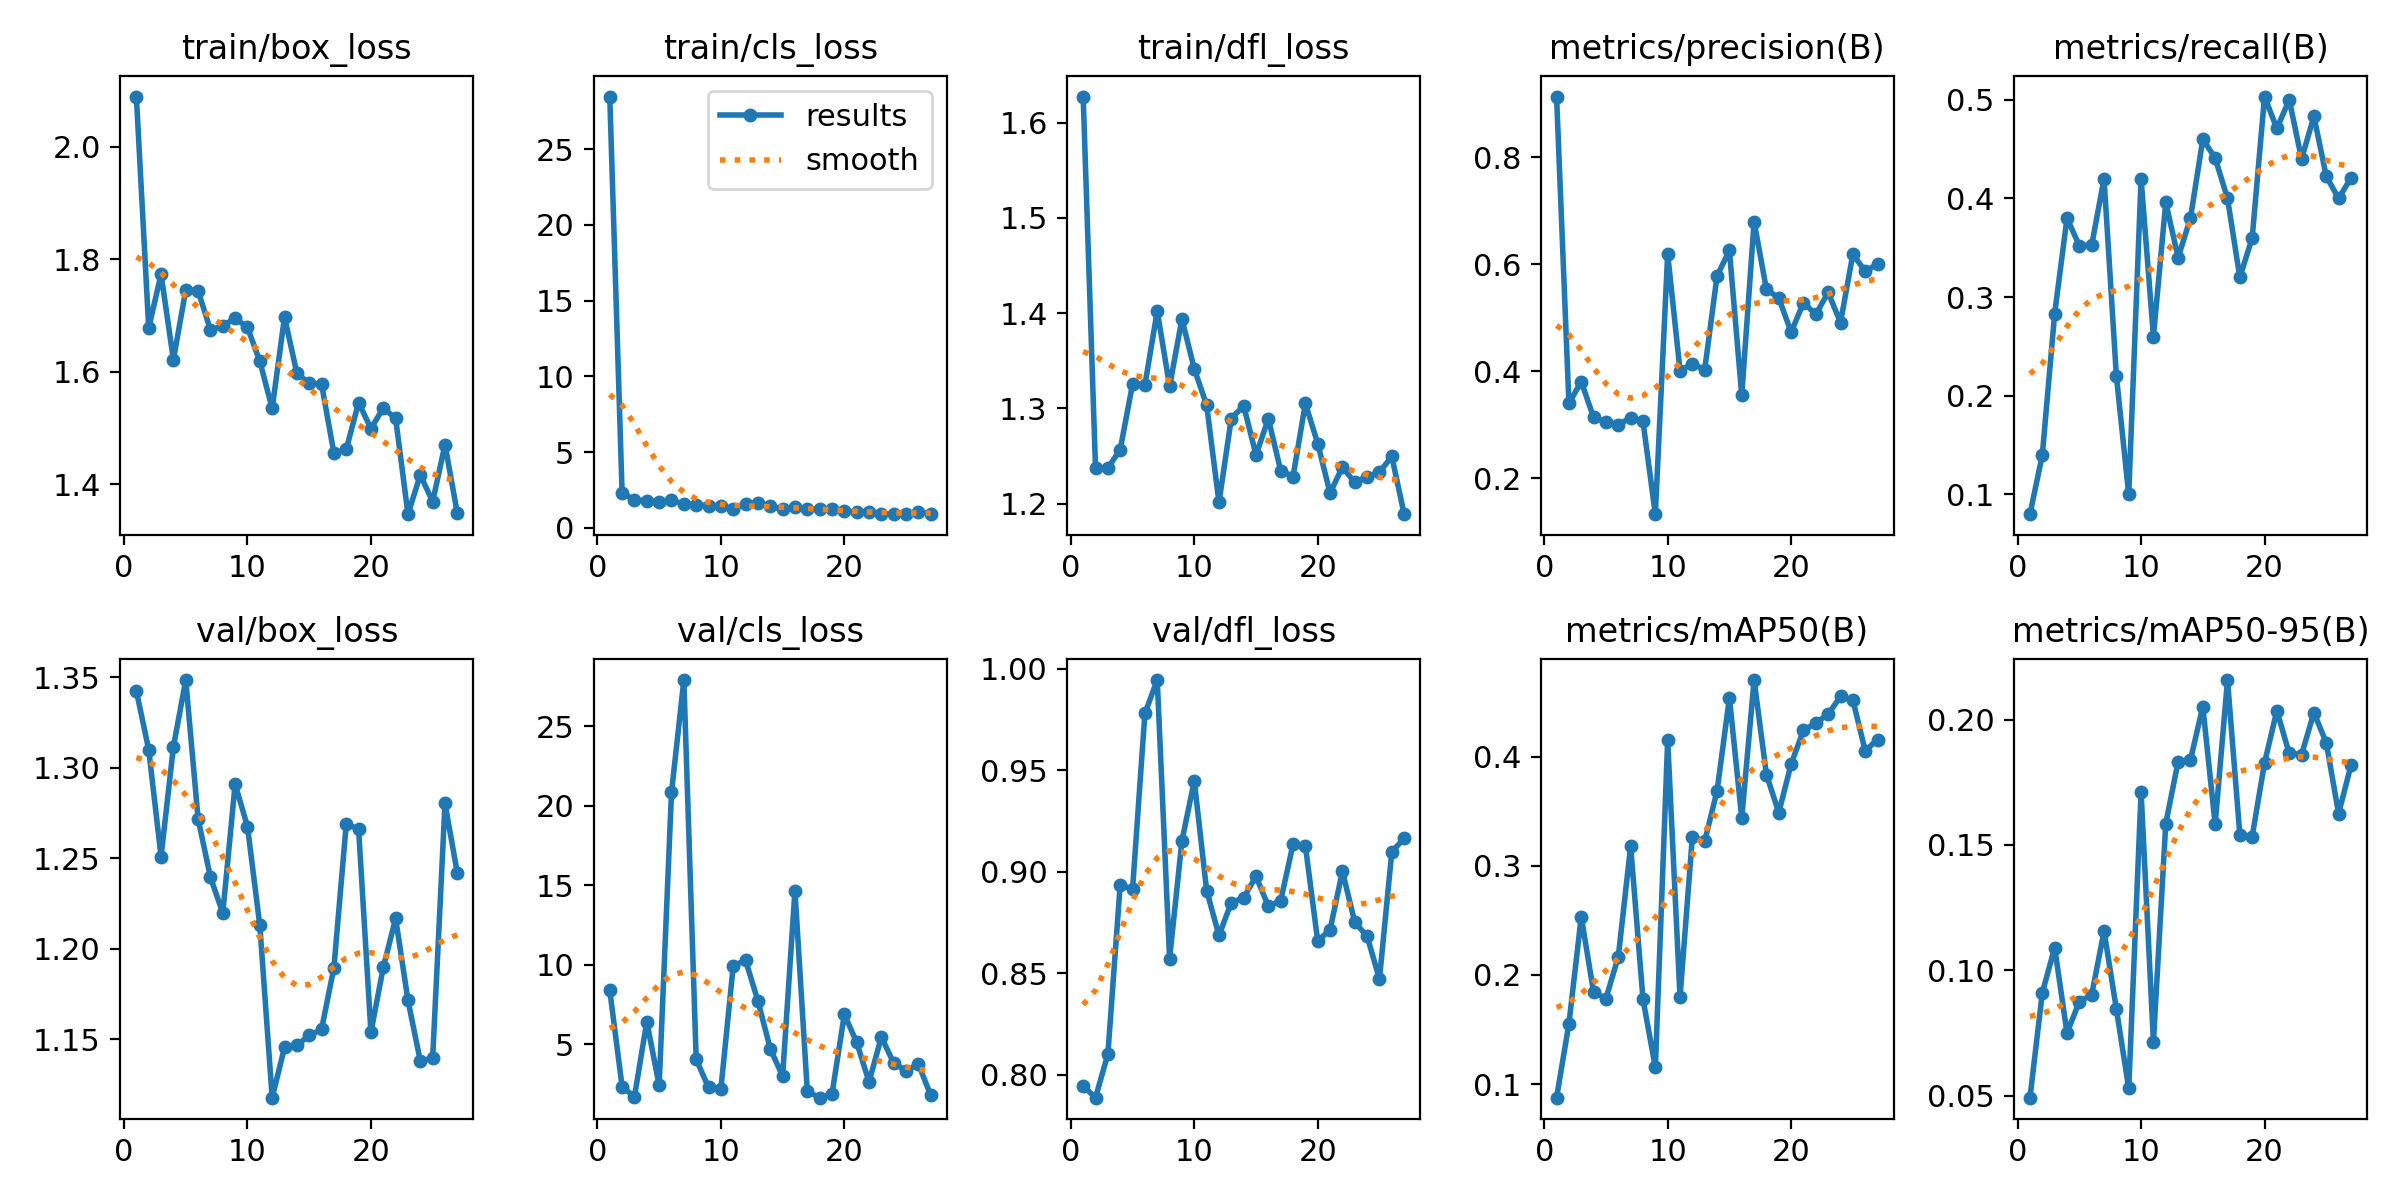

 Running inference on random validation images...

image 1/1 /content/yolo_dataset_final/images/val/20230620_160148ll.jpg: 640x480 1 number_plate, 13.1ms
Speed: 3.3ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict2
 Prediction saved for 20230620_160148ll.jpg

image 1/1 /content/yolo_dataset_final/images/val/20230707_162200.jpg: 640x480 (no detections), 12.1ms
Speed: 3.2ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict2
 Prediction saved for 20230707_162200.jpg

image 1/1 /content/yolo_dataset_final/images/val/20230620_161050ll.jpg: 640x480 1 number_plate, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict2
 Prediction saved for 20230620_161050ll.jpg

image 1/1 /content/yolo_dataset_final/images/val/20230518_092313.jpg: 640x288 (no detections), 11.2ms
S

In [24]:
from ultralytics import YOLO
from IPython.display import Image, display
import os, random

#  Load the Model
model = YOLO("runs/detect/train2/weights/best.pt")


#  MODEL EVALUATION
print(" Evaluating model on validation set...")
metrics = model.val()
print(metrics)


#  VISUALIZE TRAINING

print("📈 Showing training curves...")
results_img = "runs/detect/train2/results.png"
if os.path.exists(results_img):
    display(Image(filename=results_img))
else:
    print("No results.png found, maybe training was interrupted.")

#  INFERENCE ON SAMPLE IMAGES

print(" Running inference on random validation images...")

val_dir = "/content/yolo_dataset_final/images/val"
sample_imgs = random.sample(os.listdir(val_dir), min(5, len(os.listdir(val_dir))))

for img_file in sample_imgs:
    img_path = os.path.join(val_dir, img_file)
    results = model.predict(source=img_path, conf=0.4, save=True)
    print(f" Prediction saved for {img_file}")

print("\n Predictions saved under: runs/detect/predict/")


# SAVE BEST MODEL TO GOOGLE DRIVE

print(" Saving the best model to Google Drive...")
drive_path = "/content/drive/MyDrive/best_numberplate_model.pt"
!cp runs/detect/train2/weights/best.pt {drive_path}
print(f" Best model copied to {drive_path}")


# Post processing

In [26]:
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 31.6 MB/s eta 0:00:00


Using test image: /content/yolo_dataset_final/images/val/20230620_161316.jpg

image 1/1 /content/yolo_dataset_final/images/val/20230620_161316.jpg: 640x480 3 number_plates, 18.5ms
Speed: 17.2ms preprocess, 18.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)
🔎 OCR Result: [([[np.float64(56.78525321317669), np.float64(44.06727891859019)], [np.float64(185.88495633213822), np.float64(64.17427328667269)], [np.float64(168.21474678682333), np.float64(155.9327210814098)], [np.float64(39.1150436678618), np.float64(135.8257267133273)]], 'KLo=', np.float64(0.508689820766449)), ([[np.float64(172.118489277029), np.float64(61.038928830427565)], [np.float64(427.89716197255444), np.float64(107.56955080865424)], [np.float64(406.88151072297103), np.float64(193.96107116957242)], [np.float64(152.10283802744553), np.float64(147.43044919134576)]], '1BU8686', np.float64(0.7416408964916067))]


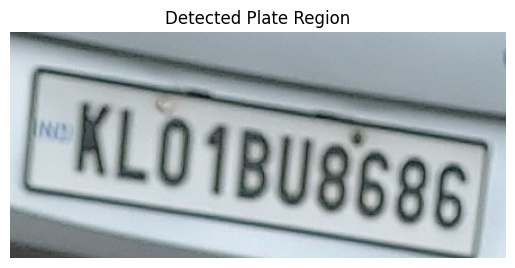

🔎 OCR Result: [([[np.float64(-0.06910606117020102), np.float64(0.057313631117136055)], [np.float64(126.12324305470797), np.float64(23.9053161093043)], [np.float64(106.0691060611702), np.float64(112.94268636888286)], [np.float64(-19.123243054707963), np.float64(89.0946838906957)]], 'KLo =', np.float64(0.4120383833943601)), ([[np.float64(110.10273295103786), np.float64(19.040335756520363)], [np.float64(365.880120337511), np.float64(62.456231197263904)], [np.float64(345.89726704896214), np.float64(149.95966424347964)], [np.float64(90.11987966248898), np.float64(105.5437688027361)]], '1BU8686 ', np.float64(0.811732199008067))]


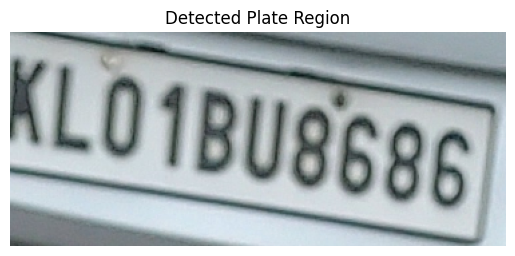

🔎 OCR Result: []


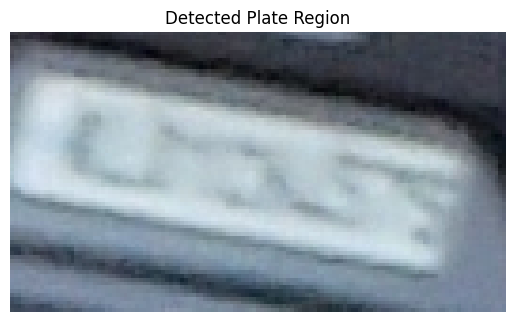

In [31]:
from ultralytics import YOLO
import cv2
import easyocr
import os
import matplotlib.pyplot as plt

# Load trained YOLO model
model = YOLO("runs/detect/train2/weights/best.pt")


val_dir = "/content/yolo_dataset_final/images/val"


test_img = os.path.join(val_dir, os.listdir(val_dir)[0])  # first image in val
print("Using test image:", test_img)


results = model.predict(test_img, conf=0.4)

# Load image
img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Extract bounding boxes
for r in results:
    for box in r.boxes.xyxy:  # x1, y1, x2, y2
        x1, y1, x2, y2 = map(int, box)
        plate_region = img[y1:y2, x1:x2]

        # Run OCR on detected plate
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(plate_region)

        print(" OCR Result:", ocr_result)

        # Show detected plate
        plt.imshow(plate_region)
        plt.title("Detected Plate Region")
        plt.axis("off")
        plt.show()


In [32]:
from google.colab import files
files.download("runs/detect/train2/weights/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>